In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.dates import date2num, num2date, DateFormatter
import datetime
import geopandas as gpd
from statsmodels.robust.robust_linear_model import RLM
import statsmodels.api as sm
from matplotlib.ticker import MultipleLocator
import pandas as pd
from shapely.geometry import Point
from matplotlib import rcParams
from scipy.stats import gaussian_kde, linregress
from math import ceil, sqrt
import cartopy.feature as cfeature

In [2]:
# Load raw water level dataset
with open("../../Result datasets/Global water level datasets (raw)/S3_globe_dataset.json",'r') as f:
    dataset=json.load(f)


{'X': [113.16451241369562,
  113.16476550320402,
  113.1650183918042,
  113.16527087874742,
  113.16552276360376,
  113.1657738464213,
  113.1660239278848,
  113.16627280947391,
  113.16652029362078,
  113.16676618386695,
  113.1670102850192,
  113.16725240330457,
  113.1674923465242,
  113.1677299242058,
  113.16796494775501,
  113.16819723060497,
  113.16842658836454,
  113.16865283896452,
  113.16887580280239,
  113.16909530288468,
  113.16931116496764,
  113.16952321769543,
  113.16973129273622,
  113.1699352249158,
  113.17013485234871,
  113.17033001656672,
  113.17052056264463,
  113.1707063393233,
  113.17088719912967,
  113.17106299849381,
  113.17123359786298,
  113.17139886181235,
  113.17155865915245,
  113.17171286303342,
  113.17186135104562,
  113.17200400531685,
  113.17214071260588,
  113.17227136439237,
  113.17239585696304,
  113.17251409149387,
  113.17262597412872,
  113.17273141605372,
  113.17283033356782,
  113.17292264814918,
  113.17300828651759,
  113.1730871

In [4]:
len(dataset) #number of raw VSs

81071

In [4]:
# Load continent boundaries
continent_shp="Continental_boundaries/continent.shp"
continent_boundary= gpd.read_file(continent_shp)
continent_boundary

,CONTINENT,geometry
0,Asia,"MULTIPOLYGON (((93.27554 80.26361, 93.31304 80..."
1,North America,"MULTIPOLYGON (((-25.28167 71.39166, -25.32889 ..."
2,Europe,"MULTIPOLYGON (((58.06138 81.68776, 57.98055 81..."
3,Africa,"MULTIPOLYGON (((0.69465 5.77337, 0.66667 5.803..."
4,South America,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
5,Oceania,"MULTIPOLYGON (((-177.39334 28.18416, -177.3958..."
6,Australia,"MULTIPOLYGON (((142.27997 -10.26556, 142.21053..."
7,Antarctica,"MULTIPOLYGON (((51.80305 -46.45667, 51.72139 -..."


<Axes: >

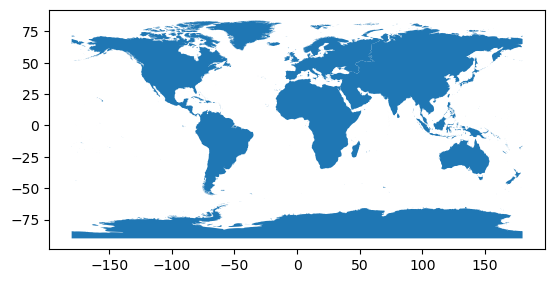

In [5]:
# Plot the continents
china_boundary= continent_boundary
china_boundary.plot()

In [6]:
import xarray as xr
# Load the wet season file 
nc_path='../Altimetry calculation/wet_season.nc'
wet_season=xr.open_dataset(nc_path)
wet_season

<xarray.Dataset>
Dimensions:       (lat: 72, lon: 144)
Coordinates:
  * lat           (lat) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon           (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Data variables:
    start_month   (lat, lon) int32 ...
    end_month     (lat, lon) int32 ...
    median_month  (lat, lon) int32 ...

## Calculate water level fluctuations and change rates for all VSs

In [ ]:
# Calculate water level change rate using robust least squares regression (RLM)
# This code:
# 1. Filters for VSs with valid monitoring time data
# 2. For each VS with sufficient data (>=10 measurements) and long enough time span (>4 years):
#    - Calculates water level fluctuation (max - min)
#    - Computes annual change rate using robust regression with Tukey's biweight
#    - Determines statistical significance (p-value)
# 3. Filters out VSs with invalid/insufficient data

new_dataset = [item for item in dataset if item['monitor_time']]

for i, item in enumerate(new_dataset):
    monitor_time=item['monitor_time']
    monitor_wse=item['monitor_wse']
    if np.size(monitor_wse)>=10:
        if (monitor_time[-1]-monitor_time[0]>365*4) & (item['width']>0):
            fluctuation2=max(monitor_wse)-min(monitor_wse)
            new_dataset[i]['fluctuation2']=fluctuation2
            model=RLM(monitor_wse,sm.add_constant(monitor_time),M=sm.robust.norms.TukeyBiweight())
            results=model.fit()
            new_dataset[i]['change_rate'] = results.params[1] * 365#m/yr
            new_dataset[i]['p_value_for_change']=results.pvalues[1]
        else:
            new_dataset[i]['fluctuation2']=[]
            new_dataset[i]['change_rate']=[]
            new_dataset[i]['p_value_for_change']=[]
    else:
        new_dataset[i]['fluctuation2']=[]
        new_dataset[i]['change_rate']=[]
        new_dataset[i]['p_value_for_change']=[]

    if i%5000==0:
        print('Progress: {:.2f} %'.format(i/len(new_dataset)*100))

new_dataset = [item for item in new_dataset if item['fluctuation2']]
len(new_dataset)

In [7]:
# Extract metadata information from new dataset
#new_dataset=dataset
lats=[item["center_lat"] for item in new_dataset]# Get all center latitude values
lons=[item["center_lon"] for item in new_dataset]# Get all center longitude values

widths=[item["width"] for item in new_dataset]# Get all width values
DEMS=[item["wse"] for item in new_dataset]# Get all water surface elevation values
fluctuations=[item["fluctuation2"] for item in new_dataset]# Get all fluctuation values
#fluctuations

[4.03404280869394, 4.66580887023526, 1.4020159877194098, 2.504999435805204, 3.5903168063552577, 2.8121667112224724, 3.3722454075058437, 2.7151624429841377, 2.965736421879029, 3.869525607983064, 3.345954192283557, 3.4530483392878466, 3.336701419834867, 2.8884246610687114, 3.2383522484345235, 3.616847008856837, 3.227978923962702, 4.008010613359787, 3.3352182683269405, 2.8815007673772186, 2.9992245487908207, 5.53958496072233, 6.068356729046428, 5.904284292952752, 4.5844224279775005, 3.7752934962963423, 5.867356899590469, 4.45205725390036, 5.3467953812870945, 1.5870592267146328, nan, 2.050446130216274, 1.6064143318958521, 4.908319914012225, 4.834349239642847, 3.8554196223993955, 3.1459987213749034, 2.8759952442562735, 3.1473862545764035, 2.871983902818826, 2.809525352134216, 3.1801723054612197, 2.6704960808610707, 2.473354257316764, 2.4222714104436385, 2.637093583746621, 2.7367498104275967, 2.2232876202032372, 4.130237136295719, 4.458516593336267, 4.575425374903375, 5.275460476619031, 4.16

<BarContainer object of 36 artists>

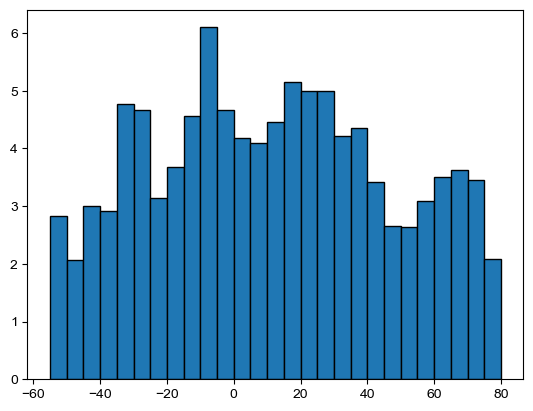

In [86]:
# Calculate water level fluctuations by latitude and longitude bins
# This code:
# 1. Creates 5-degree bins across all longitudes (-180° to 180°) and latitudes (-90° to 90°)
# 2. For each bin:
#    - Calculates mean and median fluctuation values
#    - Handles empty bins by assigning NaN values

lon_gaps=np.arange(-180,181,5)
lon_records=[]
fluctuation_mean=[]
fluctuation_median=[]
fluctuation_np=np.array(fluctuations)
width=5

for lon_i in range(len(lon_gaps)-1):
    lon_record=(lon_gaps[lon_i]+lon_gaps[lon_i+1])/2
    lon_records.append(lon_record)
    fluctuation_mask= (lons>=lon_gaps[lon_i]) & (lons<lon_gaps[lon_i+1])
    fluctuation_selected= fluctuation_np[fluctuation_mask]
    if fluctuation_selected.size > 0:
        fluctuation_mean.append(fluctuation_selected.mean())
        fluctuation_median.append(np.median(fluctuation_selected))
    else:
        fluctuation_mean.append(np.nan)  # 如果没有数据，用np.nan代替
        fluctuation_median.append(np.nan)
# array([ 73.5013,   3.4065, 135.0961,  53.5632])
lat_gaps=np.arange(-90,91,5)
lat_records=[]
fluctuation_mean_lat=[]
fluctuation_median_lat=[]

for lat_i in range(len(lat_gaps)-1):
    lat_record=(lat_gaps[lat_i]+lat_gaps[lat_i+1])/2
    lat_records.append(lat_record)
    fluctuation_mask= (lats>=lat_gaps[lat_i]) & (lats<lat_gaps[lat_i+1])
    fluctuation_selected= fluctuation_np[fluctuation_mask]
    if fluctuation_selected.size > 0:
        fluctuation_mean_lat.append(fluctuation_selected.mean())
        fluctuation_median_lat.append(np.median(fluctuation_selected))
    else:
        fluctuation_mean_lat.append(np.nan)  # 如果没有数据，用np.nan代替
        fluctuation_median_lat.append(np.nan)

print(fluctuation_median)
print(fluctuation_median_lat)
plt.bar(lat_records,fluctuation_median_lat,width,edgecolor='k',linewidth=1)

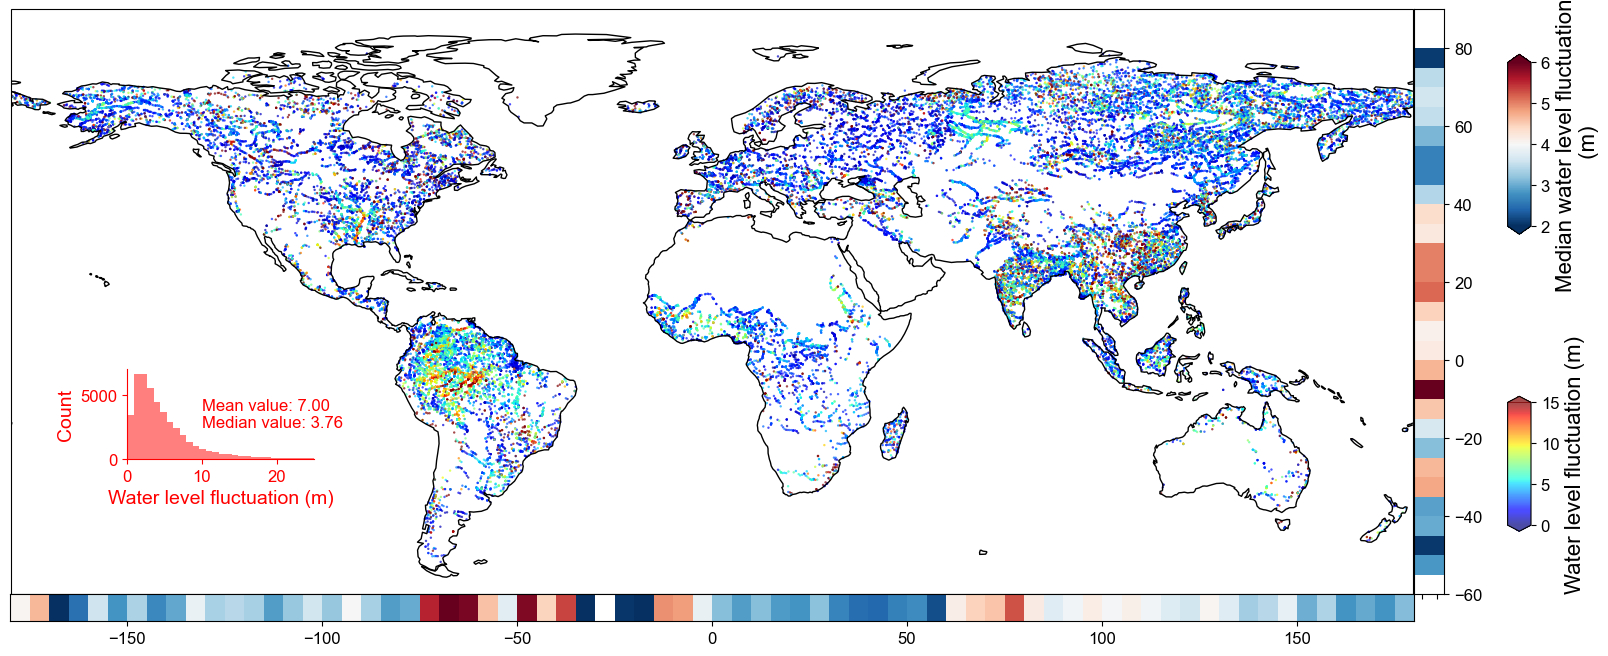

In [89]:
# Create comprehensive spatial distribution map of water level fluctuations
# This visualization includes:
# - Global map showing water level fluctuation at each virtual station
# - Median fluctuation profiles along latitude and longitude
# - Histogram of fluctuation distribution with statistics
# - Multiple coordinated axes with colorbars and annotations

bounds = china_boundary.total_bounds
lon_min=-180
lon_max=180
lat_min=-60
lat_max=90

fig=plt.figure(figsize=(23.4,9))

rect1=[0.05,0.25,0.6,0.65]
ax1=fig.add_axes(rect=rect1,projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
sizes=3
colors=fluctuations
china_boundary.plot(ax=ax1,color='w',alpha=1,linewidth=1)
scatter=ax1.scatter(lons,lats,sizes,colors,cmap='jet', alpha=0.7, 
                    edgecolors='none', linewidths=0.5, transform=ccrs.PlateCarree(),
                   vmax=15,vmin=0)

rect4=[0.69,0.32,0.01,0.15]
ax4=fig.add_axes(rect=rect4)
cbar=plt.colorbar(scatter,cax=ax4, shrink=0.7,orientation="vertical",extend="both")
cbar.set_label('Water level fluctuation (m)',fontsize=16,fontname='Arial')
cbar.ax.tick_params(labelsize=12,labelfontfamily='Arial')

levels = np.linspace(2, 6, 8)
rect6=[0.05,0.22,0.6,0.03]
ax6=fig.add_axes(rect=rect6)
X,Y=np.meshgrid(lon_records,[0,1])
Z=np.vstack((fluctuation_median,fluctuation_median))
con1=ax6.pcolormesh(X,Y,Z,cmap='RdBu_r',vmin=2,vmax=6)
ax6.set_xlim([lon_min,lon_max])
ax6.set_yticklabels([])
ax6.set_yticks([])
ax6.tick_params(labelfontfamily='Arial',labelsize=12)

rect7=[0.65,0.25,0.013,0.65]
ax7=fig.add_axes(rect=rect7)
X,Y=np.meshgrid([0,1],lat_records)
Z=np.vstack((fluctuation_median_lat,fluctuation_median_lat)).T
con2=ax7.pcolormesh(X,Y,Z,cmap='RdBu_r',vmin=2,vmax=6)
ax7.set_ylim([lat_min,lat_max])
ax7.yaxis.tick_right()
ax7.yaxis.set_label_position('right')
ax7.set_xticklabels([])
ax7.tick_params(labelfontfamily='Arial',labelsize=12)

rect8=[0.69,0.65,0.01,0.2]
ax8=fig.add_axes(rect=rect8)
cbar2=plt.colorbar(con1,cax=ax8, shrink=0.7,orientation="vertical", extend='both')
cbar2.locator=MultipleLocator(1)
cbar2.set_label('Median water level fluctuation\n (m)',fontsize=16,fontname='Arial')
cbar2.ax.tick_params(labelsize=12,labelfontfamily='Arial',labeltop=False,labelbottom=True)
#cbar2.ax.xaxis.tick_top()
cbar2.ax.set_ylim([2,6])

rect9=[0.1,0.4,0.08,0.1]
ax9=fig.add_axes(rect=rect9)
ax9.hist(fluctuations,bins=200,edgecolor='none',color='red',alpha=0.5)
ax9.set_ylabel('Count', fontname='Arial',fontsize=14,color='red')
ax9.set_xlabel('Water level fluctuation (m)', fontname='Arial',fontsize=14,color='red')
ax9.tick_params(labelsize=12,colors='red')
mean_value=np.mean(fluctuations)
median_value=np.median(fluctuations)
ax9.text(10, 2500, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='red', fontsize=12)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_color('red')
ax9.spines['bottom'].set_color('red')
ax9.set_xlim([0,25])
ax9.set_facecolor('white')

plt.show()

In [90]:
# Save the figure in PDF format
ouput_name=r'water_fluctuation_globe.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax1,))

In [91]:
# Calculate the measurement frequency for virtual stations
fluctuation_collect=[item["monitor_wse"] for item in new_dataset]
measures_number=[]
for item in fluctuation_collect:
    measures_number.append(len(item))

np.mean(measures_number)

34.03843125571894

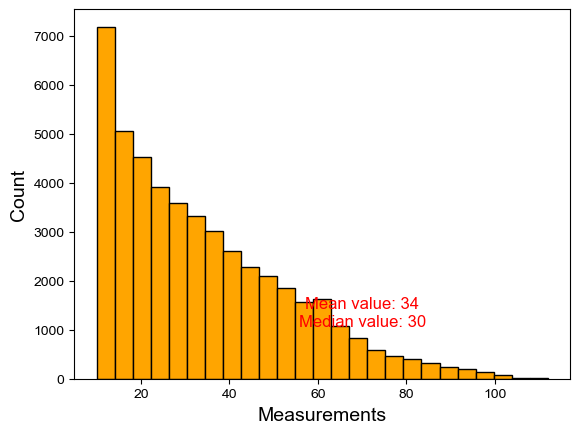

In [92]:
# Create histogram of measurement frequency distribution

plt.hist(measures_number,bins=25,edgecolor='black',color='orange')
plt.xlabel("Measurements", fontname='Arial',fontsize=14)
plt.ylabel('Count', fontname='Arial',fontsize=14)

mean_measures=np.mean(measures_number)
median_measures=np.median(measures_number)

plt.text(70, 1080, f'Mean value: {mean_measures:.0f}\nMedian value: {median_measures:.0f}', fontname='Arial', color='r', fontsize=12, horizontalalignment='center')

plt.show()

In [93]:
# Extract metadata information from new dataset
lats=[item["center_lat"] for item in new_dataset]
lons=[item["center_lon"] for item in new_dataset]

widths=[item["width"] for item in new_dataset]
DEMs=[item['wse'] for item in new_dataset]
satellites=[item["satellite"] for item in new_dataset]

S3A_mask=[satellite=='S3A' for satellite in satellites]
S3B_mask=[satellite=='S3B' for satellite in satellites]
sum(S3A_mask)+sum(S3B_mask)

46993

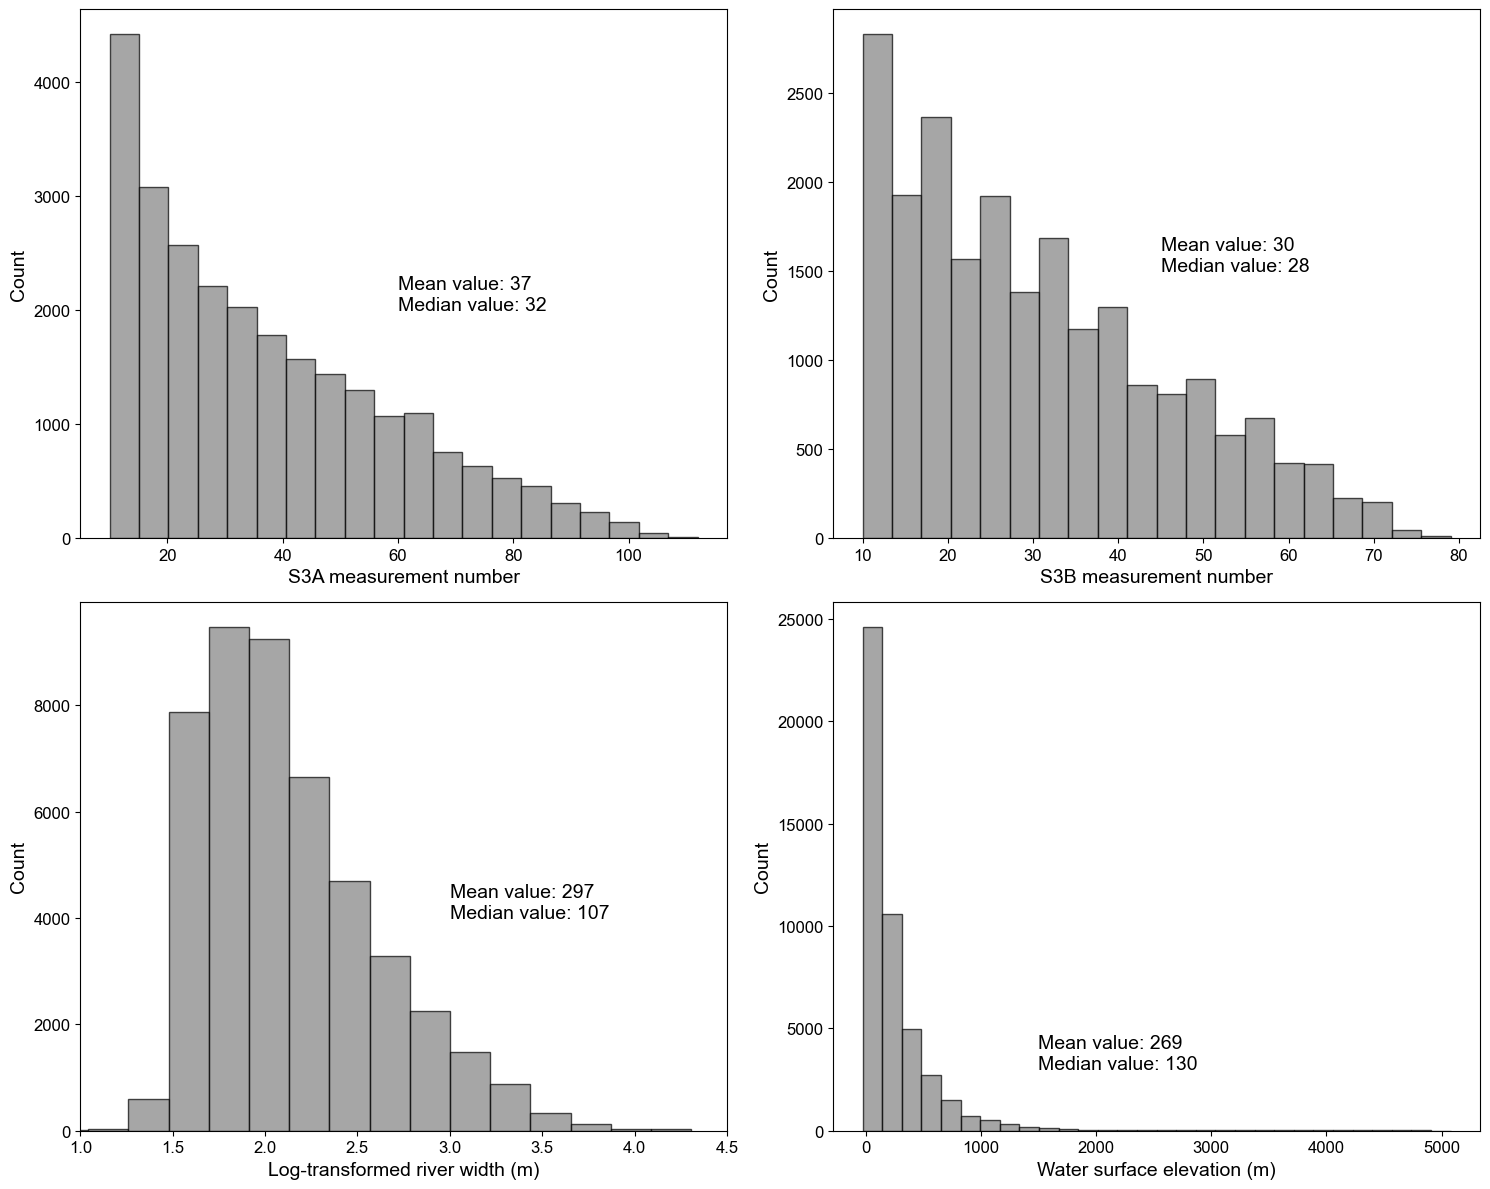

In [28]:
# Create four-panel figure showing virtual station distributions
# This visualization includes:
# - Distribution of S3A measurement counts
# - Distribution of S3B measurement counts
# - Distribution of log-transformed river widths
# - Distribution of water surface elevations
# Each panel includes mean and median statistics

rcParams['font.family'] = 'Arial'
fig=plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(2, 2, 1)  # First subplot
ax2 = fig.add_subplot(2, 2, 2)  # Second subplot
ax3 = fig.add_subplot(2, 2, 3)  # Third subplot
ax4 = fig.add_subplot(2, 2, 4)  # Fourth subplot

measures_number_np=np.array(measures_number)

S3A_measures=measures_number_np[S3A_mask]
ax1.hist(S3A_measures,bins=20,edgecolor='black',color='gray',alpha=0.7)
ax1.set_ylabel('Count', fontname='Arial',fontsize=14)
ax1.set_xlabel('S3A measurement number', fontname='Arial',fontsize=14)
ax1.tick_params(labelsize=12)
mean_measures=np.mean(S3A_measures)
median_measures=np.median(S3A_measures)
ax1.text(60, 2000, f'Mean value: {mean_measures:.0f}\nMedian value: {median_measures:.0f}', fontname='Arial', color='k', fontsize=14)

S3B_measures=measures_number_np[S3B_mask]
ax2.hist(S3B_measures,bins=20,edgecolor='black',color='gray',alpha=0.7)
ax2.set_ylabel('Count', fontname='Arial',fontsize=14)
ax2.set_xlabel('S3B measurement number', fontname='Arial',fontsize=14)
ax2.tick_params(labelsize=12)
mean_measures=np.mean(S3B_measures)
median_measures=np.median(S3B_measures)
ax2.text(45, 1500, f'Mean value: {mean_measures:.0f}\nMedian value: {median_measures:.0f}', fontname='Arial', color='k', fontsize=14)

width_log10=np.log10(widths)
ax3.hist(width_log10,bins=20,edgecolor='black',color='gray',alpha=0.7)
ax3.set_ylabel('Count', fontname='Arial',fontsize=14)
ax3.set_xlabel('Log-transformed river width (m)', fontname='Arial',fontsize=14)
ax3.tick_params(labelsize=12)
mean_measures=np.mean(widths)
median_measures=np.median(widths)
ax3.text(3, 4000, f'Mean value: {mean_measures:.0f}\nMedian value: {median_measures:.0f}', fontname='Arial', color='k', fontsize=14)
ax3.set_xlim([1,4.5])

ax4.hist(DEMs,bins=30,edgecolor='black',color='gray',alpha=0.7)
ax4.set_ylabel('Count', fontname='Arial',fontsize=14)
ax4.set_xlabel('Water surface elevation (m)', fontname='Arial',fontsize=14)
ax4.tick_params(labelsize=12)
mean_measures=np.mean(DEMs)
median_measures=np.median(DEMs)
ax4.text(1500, 3000, f'Mean value: {mean_measures:.0f}\nMedian value: {median_measures:.0f}', fontname='Arial', color='k', fontsize=14)

plt.tight_layout()
plt.show()

In [96]:
def excel_num_to_date(excel_num):#Convert Excel date numbers to python datetime
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

#Record the number of valid measurements across all VSs
monitor_years_S3A=[]
monitor_years_S3B=[]
for item in new_dataset:
    monitor_time=item['monitor_time']
    satellite=item['satellite']
    monitor_time_datetime=[excel_num_to_date(time) for time in monitor_time]
    monitor_time_year=[time.year for time in monitor_time_datetime]

    if satellite=='S3A':
        monitor_years_S3A.extend(monitor_time_year)
    else:
        monitor_years_S3B.extend(monitor_time_year)

print(len(monitor_years_S3A)+len(monitor_years_S3B))

1599568


In [69]:
# Extract metadata information from new dataset
lats=[item["center_lat"] for item in new_dataset]
lons=[item["center_lon"] for item in new_dataset]
lat_np=np.array(lats)
lon_np=np.array(lons)

widths=[item["width"] for item in new_dataset]
DEMS=[item["wse"] for item in new_dataset]
fluctuations=[item["fluctuation2"] for item in new_dataset]
change_rates=[item["change_rate"]*100 for item in new_dataset]#cm/yr
change_rate_np=np.array(change_rates)
p_values=[item["p_value_for_change"] for item in new_dataset]
p_value_np=np.array(p_values)
fluctuation_np=np.array(fluctuations)

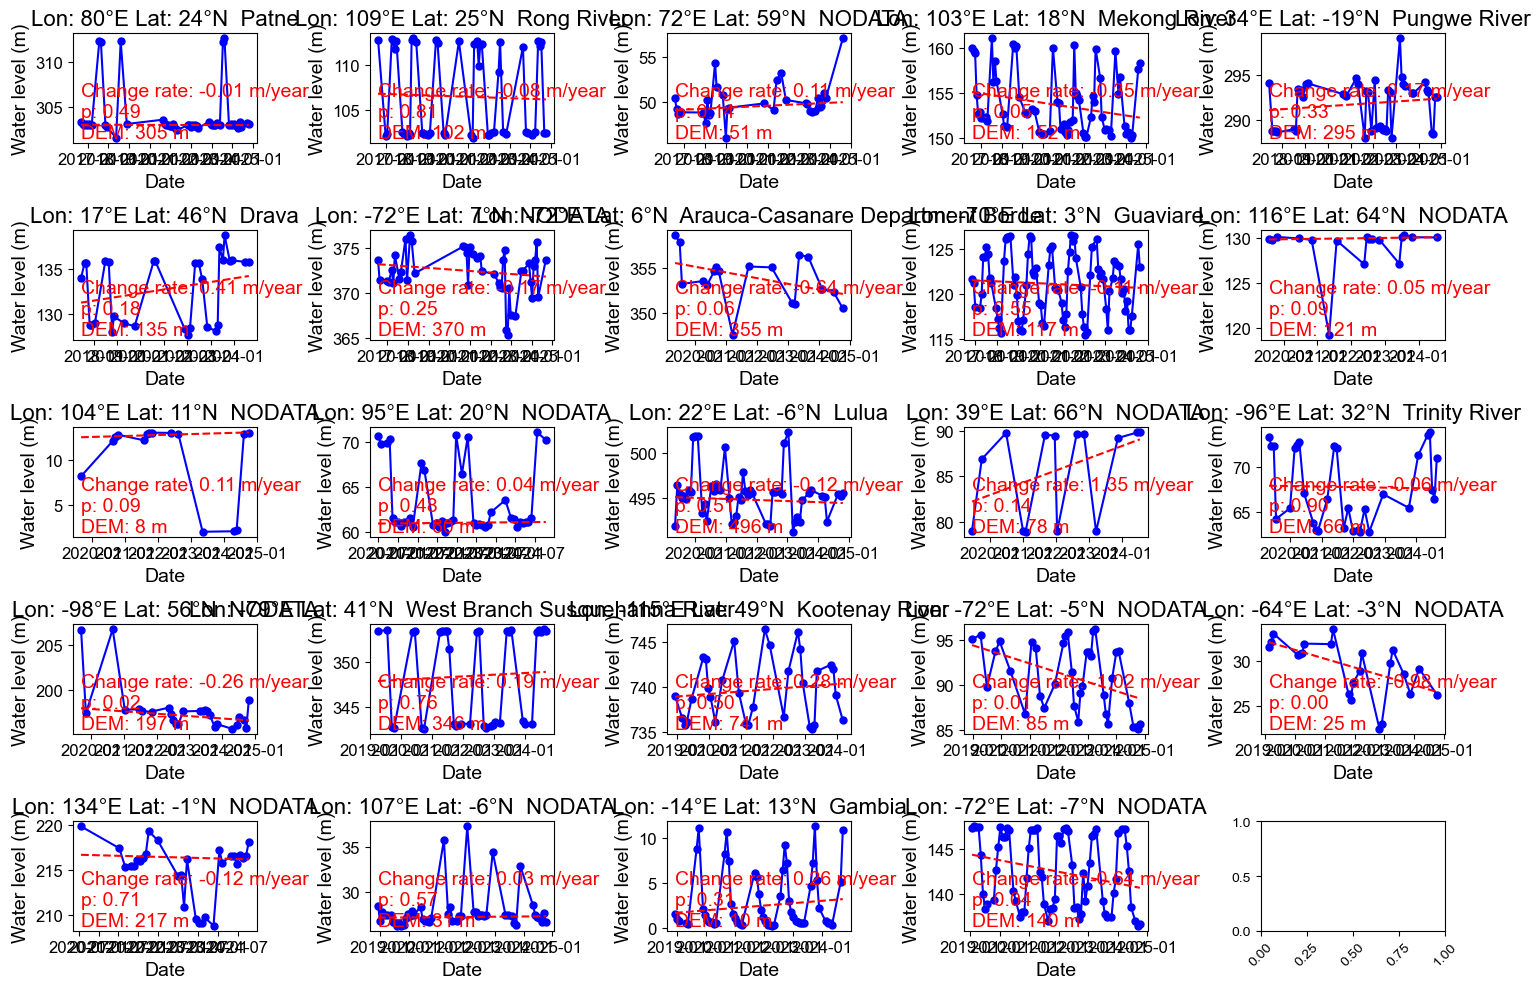

In [42]:
def excel_num_to_date(excel_num):#Convert Excel date numbers to python datetime
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

# Visualize water level time series at some VSs
index= (fluctuation_np>11) & (fluctuation_np<11.05)
filter_dataset=[item for i,item in enumerate(new_dataset) if index[i]]

num_plots= len(filter_dataset)
num_rows = ceil(sqrt(num_plots))
num_cols = ceil(num_plots / num_rows)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for fig_i in range(num_plots):
    ax = axs.flatten()[fig_i]
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['monitor_wse'],'bo-',markersize=5)
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['monitor_wse'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()
    
    fitted_stage=results.params[0]+results.params[1]*np.array(monitor_time_nums)
    ax.plot(monitor_time_dates,fitted_stage,'r--')
    ax.text(min(monitor_time_dates),
            min(filter_dataset[fig_i]['monitor_wse']),
            f'Change rate: {results.params[1]*365:.2f} m/year\np: {results.pvalues[1]:.2f}\nDEM: {filter_dataset[fig_i]['wse']:.0f} m',
           fontname='Arial', color='r', fontsize=14,verticalalignment='baseline')
    
    ax.set_xlabel('Date',fontsize=14, fontname='Arial')
    ax.set_ylabel('Water level (m)',fontsize=14, fontname='Arial')
    ax.set_title(f'Lon: {filter_dataset[fig_i]['center_lon']:.0f}°E Lat: {filter_dataset[fig_i]['center_lat']:.0f}°N  {filter_dataset[fig_i]['river']}',
                fontsize=16, fontname='Arial')
    
    ax.xaxis_date() 
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(12)

plt.tight_layout()
plt.show()

[0.2110792844729481, -3.8358899997484417, 0.33078948038985023, 3.327079479437243, 3.668426869168518, 1.0636971822775096, 0.7121077339459605, -0.11670910310388002, 1.6850767801134823, 1.5311679269994962, 1.2420336340524807, -2.5588574295427184, -3.326706895809746, -4.2619807401376715, -5.173255452160088, -3.19362447800655, -2.517199955092141, -7.114767073716466, -4.049427729416622, -0.6847042439485506, -0.7895114506506359, -2.8909070075882264, -3.470620650614367, -3.076163786780952, -3.989911706026744, -0.7413225607052601, 2.0183657290618555, 4.795444542012187, 4.988920920525729, -1.992497993297767, nan, -0.8215991611104978, 0.7968186384259051, 0.7299739414703345, 1.0158839451224875, 0.40743143234077406, 0.7038655951050128, 1.3074952967809008, 1.3712174415008977, 2.178653556970386, 1.782239302526842, 2.6288896427520445, 1.859236761253848, 0.7967781637886067, -0.2258667589498135, -1.1214824282432416, -0.3935686508173548, -2.5207739039581796, -2.7454327859000345, -3.0220155029670552, 0.83

<BarContainer object of 36 artists>

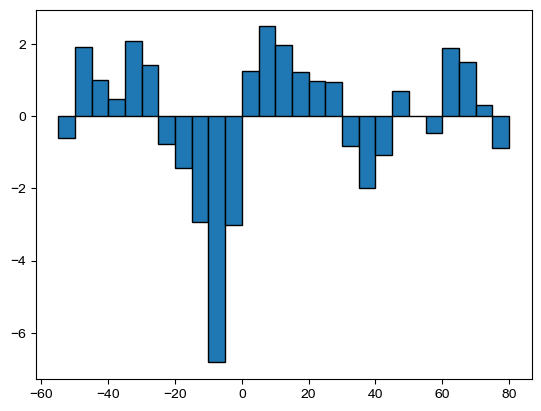

In [103]:
# Calculate water level change rates across geographic bins
# - Creates 5-degree latitude/longitude bins globally
# - Computes mean and median change rates per bin

lon_gaps=np.arange(-180,181,5)
lon_records=[]
change_mean=[]
change_median=[]
change_rates_np=np.array(change_rates)
width=5

for lon_i in range(len(lon_gaps)-1):
    lon_record=(lon_gaps[lon_i]+lon_gaps[lon_i+1])/2
    lon_records.append(lon_record)
    change_mask= (lons>=lon_gaps[lon_i]) & (lons<lon_gaps[lon_i+1])
    change_rate= change_rates_np[change_mask]
    if change_rate.size > 0:
        change_mean.append(change_rate.mean())
        change_median.append(np.median(change_rate))
    else:
        change_mean.append(np.nan)  # use nan if no VSs are included
        change_median.append(np.nan)

lat_gaps=np.arange(-90,91,5)
lat_records=[]
change_mean_lat=[]
change_median_lat=[]

for lat_i in range(len(lat_gaps)-1):
    lat_record=(lat_gaps[lat_i]+lat_gaps[lat_i+1])/2
    lat_records.append(lat_record)
    change_mask= (lats>=lat_gaps[lat_i]) & (lats<lat_gaps[lat_i+1])
    change_rate= change_rates_np[change_mask]
    if change_rate.size > 0:
        change_mean_lat.append(change_rate.mean())
        change_median_lat.append(np.median(change_rate))
    else:
        change_mean_lat.append(np.nan)  # use nan if no VSs are included
        change_median_lat.append(np.nan)

print(change_median)
print(change_median_lat)
plt.bar(lat_records,change_median_lat,width,edgecolor='k',linewidth=1)

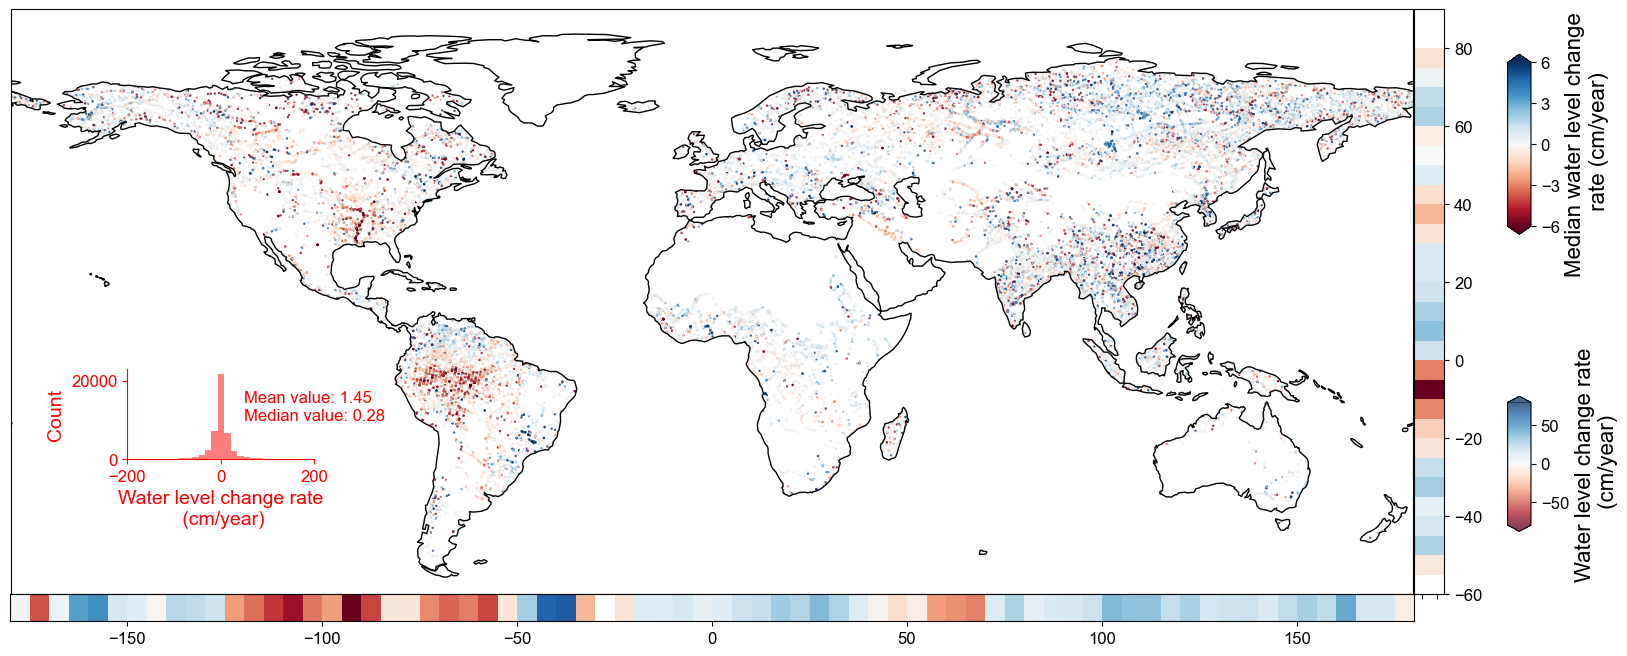

In [105]:
# Create comprehensive spatial distribution map of water level change rates
# This visualization includes:
# - Global map showing change rates at each virtual station
# - Median change rate profiles along latitude and longitude
# - Histogram of change rate distribution with statistics

bounds = china_boundary.total_bounds
lon_min=-180
lon_max=180
lat_min=-60
lat_max=90
rcParams['font.family'] = 'Arial'
fig=plt.figure(figsize=(23.4,9))

rect1=[0.05,0.25,0.6,0.65]
ax1=fig.add_axes(rect=rect1,projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
sizes=3 #np.log10(widths)*3
colors=change_rates
positive_mask= np.array(colors)>0
negative_mask= np.array(colors)<=0
china_boundary.plot(ax=ax1,color='w',alpha=1,linewidth=1)

scatter_negative = ax1.scatter(lons,
                              lats,
                              sizes,
                              colors,
                              marker='o', cmap='RdBu', alpha=0.75, vmin=-80, vmax=80,
                              edgecolors='none', transform=ccrs.PlateCarree())

rect4=[0.69,0.32,0.01,0.15]
ax4=fig.add_axes(rect=rect4)
cbar=plt.colorbar(scatter_negative,cax=ax4, shrink=0.7,orientation="vertical",extend="both")
cbar.locator=MultipleLocator(50)
cbar.set_label('Water level change rate\n (cm/year)',fontsize=16,fontname='Arial')
cbar.ax.tick_params(labelsize=12,labelfontfamily='Arial')

levels=np.linspace(-6,6,10)
rect6=[0.05,0.22,0.6,0.03]
ax6=fig.add_axes(rect=rect6)
X,Y=np.meshgrid(lon_records,[0,1])
Z=np.vstack((change_median,change_median))
con1=ax6.pcolormesh(X,Y,Z,cmap='RdBu',vmin=-6,vmax=6)
ax6.set_xlim([lon_min,lon_max])
ax6.set_yticklabels([])
ax6.set_yticks([])
ax6.tick_params(labelfontfamily='Arial',labelsize=12)

rect7=[0.65,0.25,0.013,0.65]
ax7=fig.add_axes(rect=rect7)
X,Y=np.meshgrid([0,1],lat_records)
Z=np.vstack((change_median_lat,change_median_lat)).T
con2=ax7.pcolormesh(X,Y,Z,cmap='RdBu',vmin=-6,vmax=6)
ax7.set_ylim([lat_min,lat_max])
ax7.yaxis.tick_right()
ax7.yaxis.set_label_position('right')
ax7.set_xticklabels([])
ax7.tick_params(labelfontfamily='Arial',labelsize=12)

rect8=[0.69,0.65,0.01,0.2]
ax8=fig.add_axes(rect=rect8)
cbar2=plt.colorbar(con1,cax=ax8, shrink=0.7,orientation="vertical", extend='both')
cbar2.locator=MultipleLocator(3)
cbar2.set_label('Median water level change\n rate (cm/year)',fontsize=16,fontname='Arial')
cbar2.ax.tick_params(labelsize=12,labelfontfamily='Arial',labeltop=False,labelbottom=True)
#cbar2.ax.xaxis.tick_top()
#cbar2.ax.set_ylim([-10,10])

rect9=[0.1,0.4,0.08,0.1]
ax9=fig.add_axes(rect=rect9)
ax9.hist(change_rates,bins=400,edgecolor='none',color='red',alpha=0.5)
ax9.set_ylabel('Count', fontname='Arial',fontsize=14,color='red')
ax9.set_xlabel('Water level change rate\n (cm/year)', fontname='Arial',fontsize=14,color='red')
ax9.tick_params(labelsize=12,colors='red')
mean_value=np.mean(change_rates)
median_value=np.median(change_rates)
ax9.text(50, 10000, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='red', fontsize=12)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_color('red')
ax9.spines['bottom'].set_color('red')
ax9.set_xlim([-200,200])
ax9.set_facecolor('white')

plt.show()

In [106]:
#save the figure in PDF format
ouput_name=r'globe_change_rate.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax1,))

In [70]:
# Filter significant VSs（p<0.05）
lon_np=np.array(lons)
lat_np=np.array(lats)
width_np=np.array(widths)
fluctuation_np=np.array(fluctuations)

p_mask= p_value_np<0.05
lon_evident=lon_np[p_mask]
lat_evident=lat_np[p_mask]
width_evident=width_np[p_mask]
change_rate_evident=change_rate_np[p_mask]
fluctuation_evident=fluctuation_np[p_mask]

p_mask_normal= p_value_np>=0.05
lon_normal=lon_np[p_mask_normal]
lat_normal=lat_np[p_mask_normal]
width_normal=width_np[p_mask_normal]
change_rate_normal=change_rate_np[p_mask_normal]
fluctuation_normal=fluctuation_np[p_mask_normal]

len(fluctuation_evident)

11688

[-68.69190680093172, -25.80139086252843, -216.22439422468915, 14.71506912701693, 16.399874326653357, 12.929216103542904, -7.666565793538207, -7.979065215264371, -9.202204858929822, 7.668001818362195, -11.352828368817475, -12.799813934561623, -14.138262105339896, -13.037717132627645, -14.320986587708775, -16.435958763248458, -11.644315988908483, -25.326958087262156, -13.892294588283647, -11.702381869467919, -7.624151222150524, -20.321464471704935, -28.89907511739217, -24.993919005263173, -16.705221559732202, -3.9983495988454387, 24.026493059110717, 12.183553021199474, 11.278661183458635, nan, nan, -4.224786205668163, 5.808402546964224, 15.869917072649883, 3.2043644847693478, 4.232209648290121, 7.382120369609495, 10.918386616696731, 7.725969550849264, 9.274209654997524, 8.793086278054302, 15.38467174039984, 9.114214454997484, 5.644314377803337, -4.126006785355471, -10.65873001335084, -2.935248813837669, -11.423139248735657, -19.456298761929453, -13.435734903295629, -2.5688884334484277, 1

<BarContainer object of 36 artists>

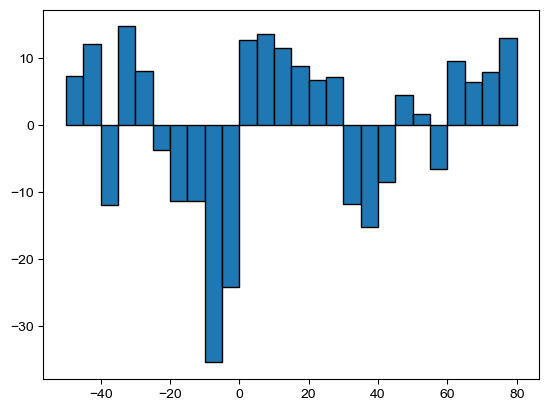

In [72]:
# Calculate spatial distribution statistics for significant VSs (p<0.05)
# - Computes median change rates in 5-degree latitude/longitude bins
# - Only includes statistically significant virtual stations

lon_gaps=np.arange(-180,181,5)
lon_records=[]
change_median_evident=[]
width=5

for lon_i in range(len(lon_gaps)-1):
    lon_record=(lon_gaps[lon_i]+lon_gaps[lon_i+1])/2
    lon_records.append(lon_record)
    change_mask= (lon_evident>=lon_gaps[lon_i]) & (lon_evident<lon_gaps[lon_i+1])
    change_rate= change_rate_evident[change_mask]
    if change_rate.size > 0:
        change_median_evident.append(np.median(change_rate))
    else:
        change_median_evident.append(np.nan)

lat_gaps=np.arange(-90,91,5)
lat_records=[]
change_median_lat_evident=[]

for lat_i in range(len(lat_gaps)-1):
    lat_record=(lat_gaps[lat_i]+lat_gaps[lat_i+1])/2
    lat_records.append(lat_record)
    change_mask= (lat_evident>=lat_gaps[lat_i]) & (lat_evident<lat_gaps[lat_i+1])
    change_rate= change_rate_evident[change_mask]
    if change_rate.size > 0:
        change_median_lat_evident.append(np.median(change_rate))
    else:
        change_median_lat_evident.append(np.nan)

print(change_median_evident)
print(change_median_lat_evident)
plt.bar(lat_records,change_median_lat_evident,width,edgecolor='k',linewidth=1)

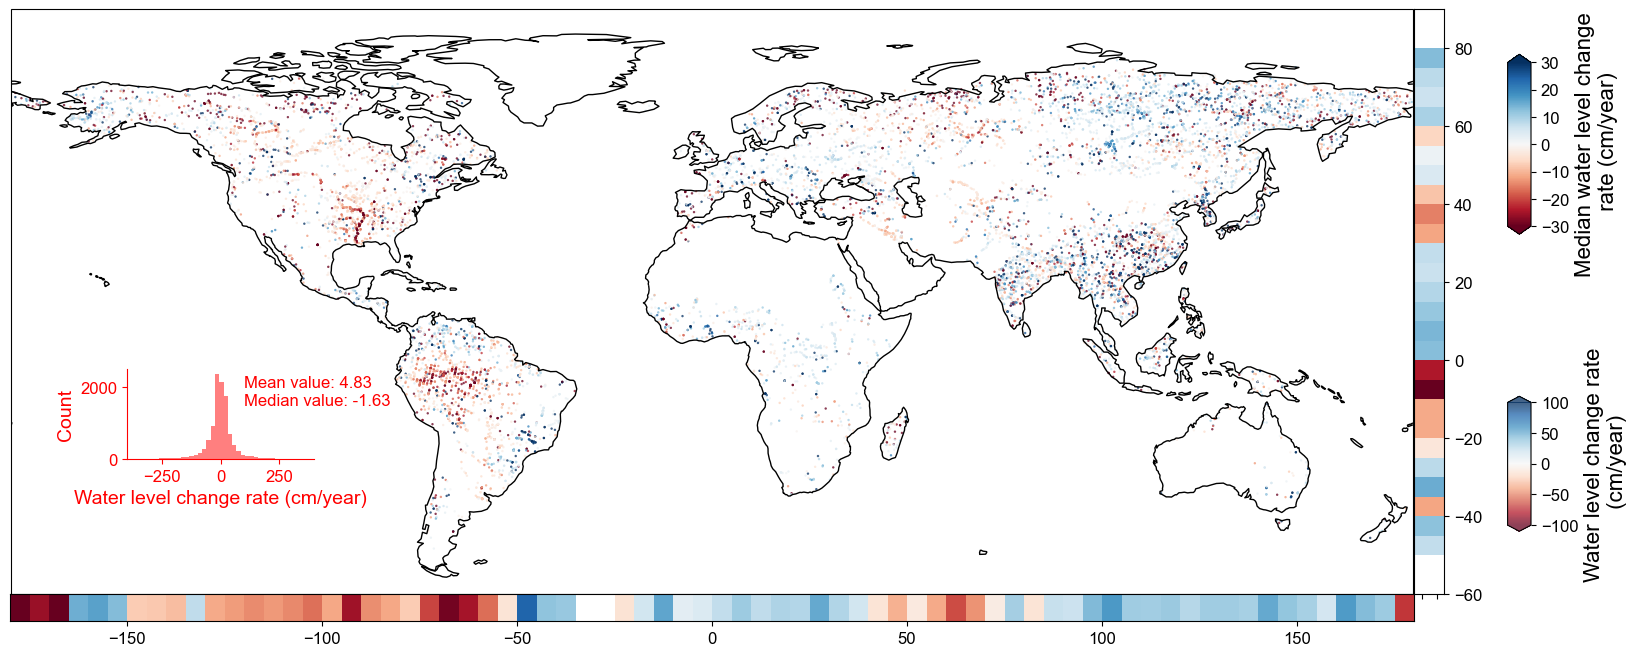

In [74]:
# Create comprehensive spatial distribution map of significant water level change rates (p<0.05)
# This visualization includes:
# - Global map showing statistically significant change rates
# - Median change rate profiles along latitude and longitude
# - Histogram of significant change rate distribution with statistics

rcParams['font.family'] = 'Arial'
fig=plt.figure(figsize=(23.4,9))

rect1=[0.05,0.25,0.6,0.65]
ax1=fig.add_axes(rect=rect1,projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
sizes=3
colors=change_rate_evident
china_boundary.plot(ax=ax1,color='w',alpha=1,linewidth=1)

scatter_negative = ax1.scatter(lon_evident,
                              lat_evident,
                              sizes,
                              colors,
                              marker='o', cmap='RdBu', alpha=0.75, vmin=-100, vmax=100,
                              edgecolors='none', transform=ccrs.PlateCarree())

rect4=[0.69,0.32,0.01,0.15]
ax4=fig.add_axes(rect=rect4)
cbar=plt.colorbar(scatter_negative,cax=ax4, shrink=0.7,orientation="vertical",extend="both")
cbar.locator=MultipleLocator(50)
cbar.set_label('Water level change rate\n (cm/year)',fontsize=16,fontname='Arial')
cbar.ax.tick_params(labelsize=12,labelfontfamily='Arial')

levels=np.linspace(-30,30,10)
rect6=[0.05,0.22,0.6,0.03]
ax6=fig.add_axes(rect=rect6)
X,Y=np.meshgrid(lon_records,[0,1])
Z=np.vstack((change_median_evident,change_median_evident))
con1=ax6.pcolormesh(X,Y,Z,cmap='RdBu',vmin=-30,vmax=30)
ax6.set_xlim([lon_min,lon_max])
ax6.set_yticklabels([])
ax6.set_yticks([])
ax6.tick_params(labelfontfamily='Arial',labelsize=12)

rect7=[0.65,0.25,0.013,0.65]
ax7=fig.add_axes(rect=rect7)
X,Y=np.meshgrid([0,1],lat_records)
Z=np.vstack((change_median_lat_evident,change_median_lat_evident)).T
con2=ax7.pcolormesh(X,Y,Z,cmap='RdBu',vmin=-30,vmax=30)
ax7.set_ylim([lat_min,lat_max])
ax7.yaxis.tick_right()
ax7.yaxis.set_label_position('right')
ax7.set_xticklabels([])
ax7.tick_params(labelfontfamily='Arial',labelsize=12)

rect8=[0.69,0.65,0.01,0.2]
ax8=fig.add_axes(rect=rect8)
cbar2=plt.colorbar(con1,cax=ax8, shrink=0.7,orientation="vertical", extend='both')
cbar2.locator=MultipleLocator(10)
cbar2.set_label('Median water level change\n rate (cm/year)',fontsize=16,fontname='Arial')
cbar2.ax.tick_params(labelsize=12,labelfontfamily='Arial',labeltop=False,labelbottom=True)
#cbar2.ax.xaxis.tick_top()
cbar2.ax.set_ylim(-30,30)

rect9=[0.1,0.4,0.08,0.1]
ax9=fig.add_axes(rect=rect9)
ax9.hist(change_rate_evident,bins=300,edgecolor='none',color='red',alpha=0.5)
ax9.set_ylabel('Count', fontname='Arial',fontsize=14,color='red')
ax9.set_xlabel('Water level change rate (cm/year)', fontname='Arial',fontsize=14,color='red')
ax9.tick_params(labelsize=12,colors='red')
mean_value=np.mean(change_rate_evident)
median_value=np.median(change_rate_evident)
ax9.text(100, 1500, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='red', fontsize=12)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_color('red')
ax9.spines['bottom'].set_color('red')
ax9.set_xlim([-400,400])
ax9.set_facecolor('white')

plt.show()

In [ ]:
#save the figure in PDF format
ouput_name=r'change_rate_evident.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax1,))

In [67]:
# Process water level data by year and calculate anomalies
# - Converts Excel dates to datetime format
# - Splits water level data into yearly segments (2016-2024) 
# - Calculates water level anomalies relative to mean
# - Compares 2023 Jul-Oct levels with historical Jul-Oct averages

def excel_num_to_date(excel_num):#convert Excel date numbers to datetime
    excel_epoch = datetime.datetime(1899, 12, 30)  
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

start_time=[42370, 42736.00, 43101.00, 43466.00 ,43831.00 ,44197.00 ,44562.00 ,44927.00 ,45292.00, 45658.00]# Define yearly start dates (2016-2025)
new_dataset2=new_dataset
for i, item in enumerate(new_dataset2):
    monitor_time = np.array(item['monitor_time'])
    monitor_time_dates = [excel_num_to_date(num) for num in item['monitor_time']]

    center_lon=item['center_lon']
    center_lat=item['center_lat']

    monitor_wse = np.array(item['monitor_wse'])#absolute water levels
    monitor_wse=monitor_wse-np.mean(monitor_wse)#project to the average level
    #split water level anomalies into yearly segments. We adopt stage anomalies to eliminate the influence of the datum
    index_2016 = (monitor_time >= start_time[0]) & (monitor_time < start_time[1])
    time_2016 = monitor_time[index_2016]
    stage_2016 = monitor_wse[index_2016]
    
    index_2017 = (monitor_time >= start_time[1]) & (monitor_time < start_time[2])
    time_2017 = monitor_time[index_2017]
    stage_2017 = monitor_wse[index_2017]

    index_2018 = (monitor_time >= start_time[2]) & (monitor_time < start_time[3])
    time_2018 = monitor_time[index_2018]
    stage_2018 = monitor_wse[index_2018]

    index_2019 = (monitor_time >= start_time[3]) & (monitor_time < start_time[4])
    time_2019 = monitor_time[index_2019]
    stage_2019 = monitor_wse[index_2019]

    index_2020 = (monitor_time >= start_time[4]) & (monitor_time < start_time[5])
    time_2020 = monitor_time[index_2020]
    stage_2020 = monitor_wse[index_2020]

    index_2021 = (monitor_time >= start_time[5]) & (monitor_time < start_time[6])
    time_2021 = monitor_time[index_2021]
    stage_2021 = monitor_wse[index_2021]

    index_2022 = (monitor_time >= start_time[6]) & (monitor_time < start_time[7])
    time_2022 = monitor_time[index_2022]
    stage_2022 = monitor_wse[index_2022]

    index_2023 = (monitor_time >= start_time[7]) & (monitor_time < start_time[8])
    time_2023 = monitor_time[index_2023]
    stage_2023 = monitor_wse[index_2023]

    index_2024 = (monitor_time >= start_time[8]) & (monitor_time < start_time[9])
    time_2024 = monitor_time[index_2024]
    stage_2024 = monitor_wse[index_2024]

    new_dataset2[i]['water_level_anomalies']=monitor_wse
    new_dataset2[i]['water_level_2016']=stage_2016
    new_dataset2[i]['water_level_2017']=stage_2017
    new_dataset2[i]['water_level_2018']=stage_2018
    new_dataset2[i]['water_level_2019']=stage_2019
    new_dataset2[i]['water_level_2020']=stage_2020
    new_dataset2[i]['water_level_2021']=stage_2021
    new_dataset2[i]['water_level_2022']=stage_2022
    new_dataset2[i]['water_level_2023']=stage_2023
    new_dataset2[i]['water_level_2024']=stage_2024
    new_dataset2[i]['monitor_time_2016']=time_2016
    new_dataset2[i]['monitor_time_2017']=time_2017
    new_dataset2[i]['monitor_time_2018']=time_2018
    new_dataset2[i]['monitor_time_2019']=time_2019
    new_dataset2[i]['monitor_time_2020']=time_2020
    new_dataset2[i]['monitor_time_2021']=time_2021
    new_dataset2[i]['monitor_time_2022']=time_2022
    new_dataset2[i]['monitor_time_2023']=time_2023
    new_dataset2[i]['monitor_time_2024']=time_2024
    # Compare 2023 Jul-Oct with historical Jul-Oct
    index_2023_JultoOct= (monitor_time >= 45108) & (monitor_time < 45231)
    stage_2023_JultoOct= monitor_wse[index_2023_JultoOct]

    index_other_JultoOct= [(date.month >= 7) & (date.month <= 10) & (date.year != 2023) for date in monitor_time_dates]
    stage_other_JultoOct= monitor_wse[index_other_JultoOct]
    # Store results if sufficient data available
    if (len(stage_2023_JultoOct)>1) & (len(stage_other_JultoOct)>3):
        new_dataset2[i]['water_level_2023_JultoOct']=np.mean(stage_2023_JultoOct)
        new_dataset2[i]['water_level_other_JultoOct']=np.mean(stage_other_JultoOct)
    else:
        new_dataset2[i]['water_level_2023_JultoOct']=[]
        new_dataset2[i]['water_level_other_JultoOct']=[]

    if i%2000==0:
        print("Progress: {:.2f} %".format(i/len(new_dataset2)*100))

len(new_dataset2)

Progress: 0.00 %
Progress: 4.26 %
Progress: 8.51 %
Progress: 12.77 %
Progress: 17.02 %
Progress: 21.28 %
Progress: 25.54 %
Progress: 29.79 %
Progress: 34.05 %
Progress: 38.30 %
Progress: 42.56 %
Progress: 46.82 %
Progress: 51.07 %
Progress: 55.33 %
Progress: 59.58 %
Progress: 63.84 %
Progress: 68.10 %
Progress: 72.35 %
Progress: 76.61 %
Progress: 80.86 %
Progress: 85.12 %
Progress: 89.38 %
Progress: 93.63 %
Progress: 97.89 %


46993

In [121]:
# Calculate difference between 2023 and historical Jul-Oct water levels

new_dataset3 = [item for item in new_dataset2 if item['water_level_2023_JultoOct']]
for i,item in enumerate(new_dataset3):
    new_dataset3[i]['difference_2023_other']=item['water_level_2023_JultoOct']-item['water_level_other_JultoOct']

len(new_dataset3)# Return number of stations with valid comparisons

25138

In [122]:
#Extract metadata (particularly the water level difference) from new_dataset3
lats=[item["center_lat"] for item in new_dataset3]
lons=[item["center_lon"] for item in new_dataset3]

widths=[item["width"] for item in new_dataset3]
DEMS=[item["wse"] for item in new_dataset3]
fluctuations=[item["fluctuation2"] for item in new_dataset3]
change_rates=[item["change_rate"]*100 for item in new_dataset3]#cm/yr
p_values=[item["p_value_for_change"] for item in new_dataset3]
change_2022_other=[item["difference_2023_other"]*100 for item in new_dataset3]

change_rate_np=np.array(change_rates)
p_value_np=np.array(p_values)
lon_np=np.array(lons)
lat_np=np.array(lats)
width_np=np.array(widths)
fluctuation_np=np.array(fluctuations)
change_2022_other_np=np.array(change_2022_other)#2022年和其他年夏季的差别

[-22.23049166491767, -17.155448028778174, 1.7313200556599373, 12.798493017675998, 13.690775021559599, 7.149015614726176, 11.10017849138466, 10.309415094401214, -6.399461311749894, -23.483150267616363, -16.860912074535506, -26.10053397164274, -18.7969881297884, -20.94485306243734, -29.350452120692076, -19.57004248457219, -31.18776880970856, -49.78320121505835, -25.404328855761815, -11.76832765950056, -9.942949666334771, -26.646358600907625, -35.90138114485133, -26.427056905340887, -19.182021559372103, 1.5963690459950053, 11.468019013130304, 15.688149155816156, 19.586467943374863, nan, nan, 1.0808219213040648, -2.3473336650503605, -21.379781854246716, -18.170040486844705, -1.9826375174722077, -0.5536028782604563, 3.816983876034986, 1.0707913166997929, 8.608353539333136, 3.516927062724112, 3.1895865830831824, -4.6702175347005745, 6.234334227681003, -0.030703282235239326, -5.01419027783504, -16.791634139438557, -28.09455276285344, -41.709511018942905, -47.578732570459984, -18.2598005574742

<BarContainer object of 36 artists>

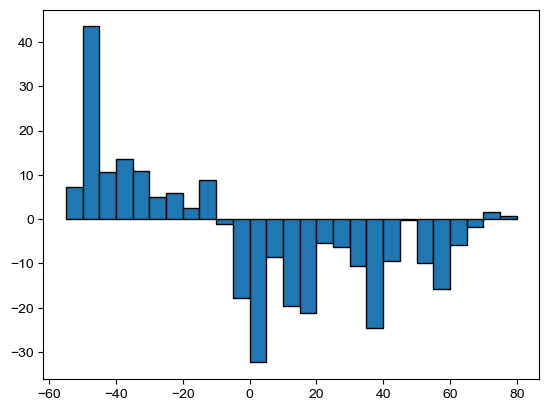

In [124]:
# Calculate spatial distribution of 2023 summer anomalies
# - Creates 5-degree latitude/longitude bins globally
# - Computes median water level differences in each bin

lon_gaps=np.arange(-180,181,5)
lon_records=[]
change_2022_median=[]
width=5

for lon_i in range(len(lon_gaps)-1):
    lon_record=(lon_gaps[lon_i]+lon_gaps[lon_i+1])/2
    lon_records.append(lon_record)
    change_mask= (lons>=lon_gaps[lon_i]) & (lons<lon_gaps[lon_i+1])
    change_rate_2022= change_2022_other_np[change_mask]
    if change_rate_2022.size > 0:
        change_2022_median.append(np.median(change_rate_2022))
    else:
        change_2022_median.append(np.nan)

lat_gaps=np.arange(-90,91,5)
lat_records=[]
change_2022_median_lat=[]

for lat_i in range(len(lat_gaps)-1):
    lat_record=(lat_gaps[lat_i]+lat_gaps[lat_i+1])/2
    lat_records.append(lat_record)
    change_mask= (lats>=lat_gaps[lat_i]) & (lats<lat_gaps[lat_i+1])
    change_rate_2022= change_2022_other_np[change_mask]
    if change_rate_2022.size > 0:
        change_2022_median_lat.append(np.median(change_rate_2022))
    else:
        change_2022_median_lat.append(np.nan)

print(change_2022_median)
print(change_2022_median_lat)
plt.bar(lat_records,change_2022_median_lat,width,edgecolor='k',linewidth=1)

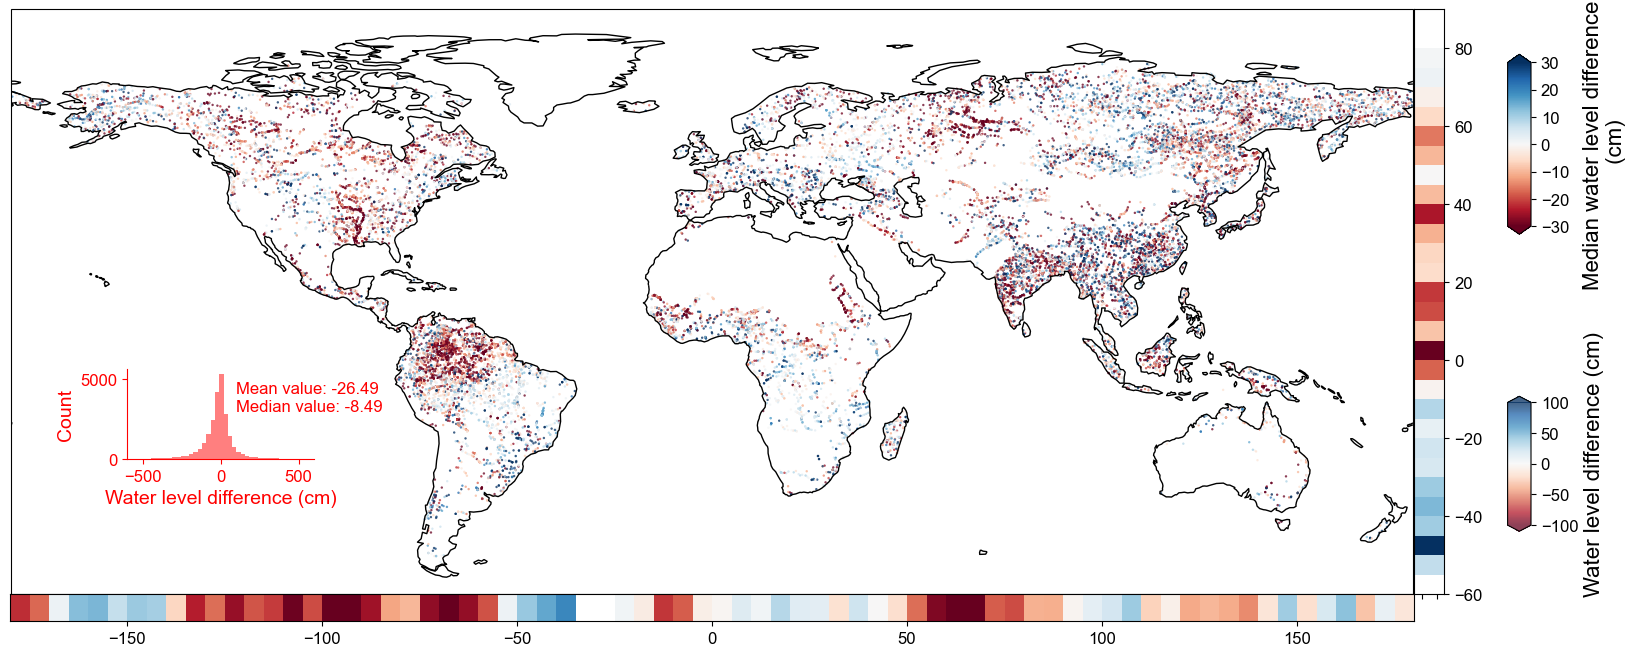

In [126]:
# Create comprehensive spatial distribution map of 2023 summer water level anomalies
# This visualization includes:
# - Global map showing water level differences between 2023 and historical Jul-Oct
# - Median difference profiles along latitude and longitude
# - Histogram of differences with statistical summary

bounds = china_boundary.total_bounds
lon_min=-180
lon_max=180
lat_min=-60
lat_max=90

rcParams['font.family'] = 'Arial'
fig=plt.figure(figsize=(23.4,9))

rect1=[0.05,0.25,0.6,0.65]
ax1=fig.add_axes(rect=rect1,projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
sizes=3
colors=change_2022_other
china_boundary.plot(ax=ax1,color='w',alpha=1,linewidth=1)

scatter_negative = ax1.scatter(lons,
                              lats,
                              sizes,
                              colors,
                              marker='o', cmap='RdBu', alpha=0.75, vmin=-100, vmax=100,
                              edgecolors='none', transform=ccrs.PlateCarree())

rect4=[0.69,0.32,0.01,0.15]
ax4=fig.add_axes(rect=rect4)
cbar=plt.colorbar(scatter_negative,cax=ax4, shrink=0.7,orientation="vertical",extend="both")
cbar.locator=MultipleLocator(50)
cbar.set_label('Water level difference (cm)',fontsize=16,fontname='Arial')
cbar.ax.tick_params(labelsize=12,labelfontfamily='Arial')

levels=np.linspace(-30,30,10)
rect6=[0.05,0.22,0.6,0.03]
ax6=fig.add_axes(rect=rect6)
X,Y=np.meshgrid(lon_records,[0,1])
Z=np.vstack((change_2022_median,change_2022_median))
con1=ax6.pcolormesh(X,Y,Z,cmap='RdBu',vmin=-30,vmax=30)
ax6.set_xlim([lon_min,lon_max])
ax6.set_yticklabels([])
ax6.set_yticks([])
ax6.tick_params(labelfontfamily='Arial',labelsize=12)

rect7=[0.65,0.25,0.013,0.65]
ax7=fig.add_axes(rect=rect7)
X,Y=np.meshgrid([0,1],lat_records)
Z=np.vstack((change_2022_median_lat,change_2022_median_lat)).T
con2=ax7.pcolormesh(X,Y,Z,cmap='RdBu',vmin=-30,vmax=30)
ax7.set_ylim([lat_min,lat_max])
ax7.yaxis.tick_right()
ax7.yaxis.set_label_position('right')
ax7.set_xticklabels([])
ax7.tick_params(labelfontfamily='Arial',labelsize=12)

rect8=[0.69,0.65,0.01,0.2]
ax8=fig.add_axes(rect=rect8)
cbar2=plt.colorbar(con1,cax=ax8, shrink=0.7,orientation="vertical", extend='both')
cbar2.locator=MultipleLocator(10)
cbar2.set_label('Median water level difference\n (cm)',fontsize=16,fontname='Arial',labelpad=10)
cbar2.ax.tick_params(labelsize=12,labelfontfamily='Arial',labeltop=False,labelbottom=True)
#cbar2.ax.xaxis.tick_top()
cbar2.ax.set_ylim([-30,30])

rect9=[0.1,0.4,0.08,0.1]
ax9=fig.add_axes(rect=rect9)
ax9.hist(change_2022_other,bins=500,edgecolor='none',color='red',alpha=0.5)
ax9.set_ylabel('Count', fontname='Arial',fontsize=14,color='red')
ax9.set_xlabel('Water level difference (cm)', fontname='Arial',fontsize=14,color='red')
ax9.tick_params(labelsize=12,colors='red')
mean_value=np.mean(change_2022_other_np)
median_value=np.median(change_2022_other_np)
ax9.text(100, 3000, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='red', fontsize=12)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_color('red')
ax9.spines['bottom'].set_color('red')
ax9.set_xlim([-600,600])
ax9.set_facecolor('white')

plt.show()

In [127]:
#save the figure in PDF format
ouput_name=r'change_extreme_2023_summer_globe.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax1,))

In [77]:
# Save processed dataset to JSON file with proper type conversion
import json

def convert_to_native_type(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_native_type(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_type(element) for element in obj]
    else:
        return obj
# Save to JSON file
filename_total = "../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2.json"

# 将数据写入 JSON 文件
with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(new_dataset2), f, indent=4)


print('Export complete')

已全部导出


In [78]:
# split processed dataset by continents and save as the seperate JSON file (for Asia)
dataset_as=[item for item in new_dataset2 if item['continent']=='Asia']
print(len(dataset_as))
filename_total = "../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2_as.json"

with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(dataset_as), f, indent=4)

print('Export complete')

21213
全部导出


In [79]:
# split processed dataset by continents and save as the seperate JSON file (for Africa)
dataset_as=[item for item in new_dataset2 if item['continent']=='Africa']
print(len(dataset_as))
filename_total = "../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2_af.json"

with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(dataset_as), f, indent=4)

print('Export complete')

3440
全部导出


In [80]:
# split processed dataset by continents and save as the seperate JSON file (for North America)
dataset_as=[item for item in new_dataset2 if item['continent']=='North America']
print(len(dataset_as))
filename_total = "../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2_na.json"

with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(dataset_as), f, indent=4)

print('Export complete')

8520
全部导出


In [81]:
# split processed dataset by continents and save as the seperate JSON file (for South America)
dataset_as=[item for item in new_dataset2 if item['continent']=='South America']
print(len(dataset_as))
filename_total = "../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2_sa.json"

with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(dataset_as), f, indent=4)

print('Export complete')

6368
全部导出


In [82]:
# split processed dataset by continents and save as the seperate JSON file (for Europe)
dataset_as=[item for item in new_dataset2 if item['continent']=='Europe']
print(len(dataset_as))
filename_total = "../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2_eu.json"

# 将数据写入 JSON 文件
with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(dataset_as), f, indent=4)

print('Export complete')

5771
全部导出


In [83]:
# split processed dataset by continents and save as the seperate JSON file (for Oceania)
dataset_as=[item for item in new_dataset2 if item['continent']=='Oceania']
print(len(dataset_as))
filename_total = "../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2_oc.json"

# 将数据写入 JSON 文件
with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(dataset_as), f, indent=4)

print('Export complete')

1681
全部导出


## Construct region-level stage time series for six continents

In [ ]:
# Create time series analysis of water level anomalies for North America
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

filter_dataset=[item for item in new_dataset2 if item['continent']=='North America']

def excel_num_to_date(excel_num):#convert Excel date numbers to datetime
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.01,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)

#Analysis of change rates during 2016-2024
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)# use a monthly sliding window to capture the median anomaly
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)

model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[0],-2,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='left')

#Analysis of change rates during 2019-2024
dates_lim=[datetime.datetime(2019, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[1],2,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='right')

ax.xaxis_date() 
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-2.5,2.5])
plt.tight_layout()
plt.show()

In [ ]:
#save the figure in PDF format
ouput_name=r'water_level_na_window2.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax,))

In [ ]:
# Create time series analysis of water level anomalies for South America
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

filter_dataset=[item for item in new_dataset2 if item['continent']=='South America']
def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.01,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)

model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]

ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[0],-3,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='left')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[1],3,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='right')

ax.xaxis_date() 
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-4,4])
plt.tight_layout()
plt.show()

In [ ]:
#save the figure in PDF format
ouput_name=r'water_level_sa_window2.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax,))

In [ ]:
# Create time series analysis of water level anomalies for Europe
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

filter_dataset=[item for item in new_dataset2 if item['continent']=='Europe']
def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.01,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)

model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]

ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[0],-0.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='left')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[1],0.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='right')

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m')) 
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-1,1])
plt.tight_layout()
plt.show()

In [ ]:
#save the figure in PDF format
ouput_name=r'water_level_eu_window2.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax,))

In [ ]:
# Create time series analysis of water level anomalies for Africa
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

filter_dataset=[item for item in new_dataset2 if item['continent']=='Africa']
def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30) 
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.01,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)

model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]

ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[0],-1.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='left')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[1],1.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='right')

ax.xaxis_date() 
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-2.5,2.5])
plt.tight_layout()
plt.show()

In [ ]:
#save the figure in PDF format
ouput_name=r'water_level_af_window2.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax,))

In [ ]:
# Create time series analysis of water level anomalies for Oceania
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

filter_dataset=[item for item in new_dataset2 if item['continent']=='Oceania']
def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.01,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)

model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]

ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[0],-1.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='left')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[1],1.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='right')

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-2,2])
plt.tight_layout()
plt.show()

In [ ]:
#save the figure in PDF format
ouput_name=r'water_level_oc_window2.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax,))

In [ ]:
# Create time series analysis of water level anomalies for Asia
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

filter_dataset=[item for item in new_dataset2 if (item['continent']=='Asia')]
def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.01,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)

model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]

ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[0],-2,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='left')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[1],2,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='right')

ax.xaxis_date() 
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-2.5,2.5])
plt.tight_layout()
plt.show()

In [ ]:
#save the figure in PDF format
ouput_name=r'water_level_as_window2.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax,))

## Water level time series for four hotspot regions

In [ ]:
# Create time series analysis of water level anomalies for Central Siberia
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024
from shapely.geometry import Point, Polygon

def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30) 
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

lon_np=np.array([item['center_lon'] for item in new_dataset2])
lat_np=np.array([item['center_lat'] for item in new_dataset2])
fluctuation_np=np.array([item['fluctuation2'] for item in new_dataset2])

selected_roi=Polygon([(82,71),(140,71),(140,50),(82,50)])
in_polygon = [selected_roi.contains(Point(lon, lat)) for lon, lat in zip(lon_np, lat_np)]

index= (in_polygon) & (fluctuation_np<15)
#index= (fluctuation_np>5) & (fluctuation_np<5.1)
filter_dataset=[item for i,item in enumerate(new_dataset2) if index[i]]
print(len(filter_dataset))

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.2,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[1],-1.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='right')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[0],1.7,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='left')

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m')) 
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-2,2])
plt.tight_layout()
plt.show()

In [ ]:
# Create time series analysis of water level anomalies for Western Siberia
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

from shapely.geometry import Point, Polygon

def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

lon_np=np.array([item['center_lon'] for item in new_dataset2])
lat_np=np.array([item['center_lat'] for item in new_dataset2])
fluctuation_np=np.array([item['fluctuation2'] for item in new_dataset2])
selected_roi=Polygon([(60,71),(80,71),(80,50),(60,50)])
in_polygon = [selected_roi.contains(Point(lon, lat)) for lon, lat in zip(lon_np, lat_np)]

index= (in_polygon) & (fluctuation_np<15)
#index= (fluctuation_np>5) & (fluctuation_np<5.1)
filter_dataset=[item for i,item in enumerate(new_dataset2) if index[i]]
print(len(filter_dataset))

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.2,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[1],-3,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='right')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[0],3,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='left')

ax.xaxis_date() 
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m')) 
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-5,5])
plt.tight_layout()
plt.show()

In [ ]:
# Create time series analysis of water level anomalies for Amazon
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

from shapely.geometry import Point, Polygon
'''
Coordinates：

Northwest corner: 2°N, 76°W (Andean headwaters region)
Northeast corner: 5°N, 50°W (River mouth region)
Southeast corner: 15°S, 45°W (Southern tributaries in Brazil)
Southwest corner: 17°S, 72°W (Bolivian tributary region)

'''
def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

lon_np=np.array([item['center_lon'] for item in new_dataset2])
lat_np=np.array([item['center_lat'] for item in new_dataset2])
fluctuation_np=np.array([item['fluctuation2'] for item in new_dataset2])

selected_roi=Polygon([(-76,2),(-50,5),(-45,-15),(-72,-17)])
in_polygon = [selected_roi.contains(Point(lon, lat)) for lon, lat in zip(lon_np, lat_np)]

index= (in_polygon) & (fluctuation_np<15)
#index= (fluctuation_np>5) & (fluctuation_np<5.1)
filter_dataset=[item for i,item in enumerate(new_dataset2) if index[i]]
print(len(filter_dataset))

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.2,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[1],-3.5,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='right')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[0],3.5,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='left')

ax.xaxis_date() 
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-4,4])
plt.tight_layout()
plt.show()

In [ ]:
# Create time series analysis of water level anomalies for Great Plains
# This visualization includes:
# - Individual station anomalies
# - Running median and quartile ranges
# - change analysis for 2016-2024 and 2019-2024

from shapely.geometry import Point, Polygon
'''
Coordinates:

Northwest corner: 47°N, 111°W (Missouri River headwaters)
Northeast corner: 45°N, 89°W (Great Lakes region)
Southeast corner: 29°N, 89°W (Mississippi River mouth)
Southwest corner: 32°N, 106°W (Rio Grande tributary)
'''
def excel_num_to_date(excel_num):
    excel_epoch = datetime.datetime(1899, 12, 30) 
    delta = datetime.timedelta(days=excel_num)
    return excel_epoch + delta

lon_np=np.array([item['center_lon'] for item in new_dataset2])
lat_np=np.array([item['center_lat'] for item in new_dataset2])
fluctuation_np=np.array([item['fluctuation2'] for item in new_dataset2])

selected_roi=Polygon([(-105,47),(-85,45),(-85,29),(-96,32)])
in_polygon = [selected_roi.contains(Point(lon, lat)) for lon, lat in zip(lon_np, lat_np)]

index= (in_polygon) & (fluctuation_np<15)
#index= (fluctuation_np>5) & (fluctuation_np<5.1)
filter_dataset=[item for i,item in enumerate(new_dataset2) if index[i]]
print(len(filter_dataset))

fig, ax = plt.subplots(figsize=(10, 6))
slope=[]
intercept=[]
date_collect=[]
wse_collect=[]

for fig_i in range(len(filter_dataset)):
    monitor_time_dates = [excel_num_to_date(num) for num in filter_dataset[fig_i]['monitor_time']]
    
    ax.plot(monitor_time_dates,filter_dataset[fig_i]['water_level_anomalies'],color='gray',alpha=0.2,linestyle='-')
    
    monitor_time_nums = date2num(monitor_time_dates)
    model=RLM(filter_dataset[fig_i]['water_level_anomalies'],sm.add_constant(monitor_time_nums),M=sm.robust.norms.TukeyBiweight())
    results=model.fit()

    date_collect.append(monitor_time_nums)
    wse_collect.append(filter_dataset[fig_i]['water_level_anomalies'])
    slope.append(results.params[1])
    intercept.append(results.params[0])
    
ax.set_xlabel('Date',fontsize=18, fontname='Arial')
ax.set_ylabel('Water level anomaly (m)',fontsize=18, fontname='Arial')
slope_median=np.median(slope)
intercept_median=np.median(intercept)
date_collect=np.concatenate(date_collect)
wse_collect=np.concatenate(wse_collect)
dates_lim=[datetime.datetime(2016, 9, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)

date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
stage_75=[]
stage_25=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
    stage_75.append(np.percentile(wse_selected,75))
    stage_25.append(np.percentile(wse_selected,25))

ax.plot(date_records,stage_50,color='red',linestyle='-',linewidth=0.5,zorder=3)
ax.fill_between(date_records, stage_75, stage_25, color='pink', alpha=0.4,zorder=2)
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='red',linestyle='--',linewidth=1)
ax.text(dates_lim[1],-2.5,f'Slope: {slope_median*365*100:.2f} cm/year',color='red',fontsize=18,va='center',ha='right')

dates_lim=[datetime.datetime(2019, 11, 1),datetime.datetime(2024, 11, 1)]
dates_num=date2num(dates_lim)
date_gaps=np.arange(dates_num[0],dates_num[1],30)
date_records=[]
stage_50=[]
for date_i in range(len(date_gaps)-1):
    date_record=(date_gaps[date_i]+date_gaps[date_i+1])/2
    date_records.append(date_record)
    date_mask= (date_collect>=date_gaps[date_i]) & (date_collect<date_gaps[date_i+1])
    wse_selected= wse_collect[date_mask]
    stage_50.append(np.median(wse_selected))
model=RLM(stage_50,sm.add_constant(date_records),M=sm.robust.norms.TukeyBiweight())
slope_median=model.fit().params[1]
intercept_median=model.fit().params[0]
ax.plot(dates_lim,slope_median*dates_num+intercept_median,color='blue',linestyle='--',linewidth=1)
ax.text(dates_lim[0],3.5,f'Slope: {slope_median*365*100:.2f} cm/year',color='blue',fontsize=18,va='center',ha='left')

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m')) 
plt.xticks(rotation=45)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)

ax.set_ylim([-3,4])
plt.tight_layout()
plt.show()